In [149]:
#load the libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [150]:
#Data Loading

#define the local file path
file_path = "C:\Z_Docs\Aspire\CoLab\HealthData\insurance.csv"

# Read the uploaded file into a df_initialFrame
data = pd.read_csv(file_path)

# Display the first few rows of the df_initialFrame
print(data.shape)
print(data.head())

(1338, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [151]:
# Descriptive Statistics:Vizualize the data distribution and statistics

# Descriptive Statistics
numerical_stats = data.describe()
categorical_stats = data.describe(include=['object'])

# Display Descriptive Statistics
print("Numerical Statistics:")
print(numerical_stats)
print("\nCategorical Statistics:")
print(categorical_stats)


Numerical Statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

Categorical Statistics:
         sex smoker     region
count   1338   1338       1338
unique     2      2          4
top     male     no  southeast
freq     676   1064        364


In [152]:
#Task: Transformation: Data Transformation
        

#Diplay missing values
missing_values = data.isna().sum()
print("Is Nan")
print(missing_values)
missing_values = data.isnull().sum()
print("Is Null")
print(missing_values)

#given that there is no missing values Data Imputation is skipped

# Clean data from outliers
numerical_columns = ['age', 'bmi','charges']
def detect_and_clean_outliers(data, numerical_columns):
    data_cleaned = data.copy()
    for column in numerical_columns:
        Q1 = data_cleaned[column].quantile(0.25)
        Q3 = data_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data_cleaned = data_cleaned[(data_cleaned[column] >= lower_bound) & (data_cleaned[column] <= upper_bound)]
    return data_cleaned

cleaned_data = detect_and_clean_outliers(data, numerical_columns)

# Debugging: Check the shape and head of the cleaned data
print("Shape of cleaned data:", cleaned_data.shape)
print(cleaned_data.head())

Is Nan
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Is Null
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Shape of cleaned data: (1191, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [153]:
#Task: Transformation: One-Hot encoding

categorical_columns = ['sex','smoker','region']

if not cleaned_data.empty:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_data = pd.DataFrame(encoder.fit_transform(cleaned_data[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))
else:
    raise ValueError("The cleaned dataset is empty after preprocessing steps.")


# merge encoded columns
cleaned_data = cleaned_data.drop(columns=categorical_columns)
cleaned_data = pd.concat([cleaned_data, encoded_data], axis=1)

# change charges to 1 or 0 over a threshold value of 10000
cleaned_data['charges'] = (cleaned_data['charges'] >= 5000).astype(int)

# Ensure no NaNs in the dataset after encoding
cleaned_data = cleaned_data.dropna()

# Debugging: Check the shape and head of the cleaned data
print("Shape of cleaned data:", cleaned_data.shape)
print(cleaned_data.head())

print("NaNs in final cleaned data:")
print(cleaned_data.isnull().sum())

Shape of cleaned data: (1060, 9)
    age     bmi  children  charges  sex_male  smoker_yes  region_northwest  \
0  19.0  27.900       0.0        1       0.0         1.0               0.0   
1  18.0  33.770       1.0        0       1.0         0.0               0.0   
2  28.0  33.000       3.0        0       1.0         0.0               0.0   
3  33.0  22.705       0.0        1       1.0         0.0               1.0   
4  32.0  28.880       0.0        0       1.0         0.0               1.0   

   region_southeast  region_southwest  
0               0.0               1.0  
1               1.0               0.0  
2               1.0               0.0  
3               0.0               0.0  
4               0.0               0.0  
NaNs in final cleaned data:
age                 0
bmi                 0
children            0
charges             0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64


In [154]:
#Split the data into Training, Validation and Test Set

def split_data(data, target_column, test_size=0.2, val_size=0.1, random_state=42):
    X = data.drop(columns=[target_column])
    y = data[target_column]
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(cleaned_data, target_column='charges')


In [155]:
#Logistic Regression Model 

# Build the logistic regression model
def build_logistic_regression_model(X_train, y_train):
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    return model

model = build_logistic_regression_model(X_train, y_train)


In [156]:
# Hyperparameter tuning
def hyperparameter_tuning(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='f1')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_

best_model = hyperparameter_tuning(X_train, y_train)
# Print model parameters
print("Model coefficients:", best_model.coef_)
print("Model intercept:", best_model.intercept_)

Model coefficients: [[ 0.22293408 -0.07060948  0.38063086  0.02655321  0.014903    0.
  -0.23925782 -0.33545036]]
Model intercept: [-4.7244875]


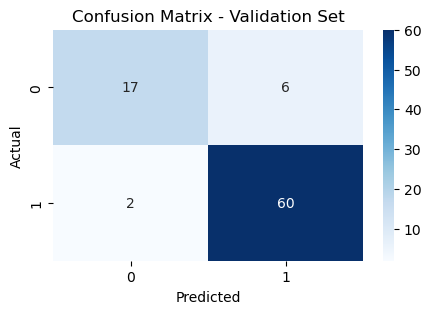

Classification Report - Validation Set:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        23
           1       0.91      0.97      0.94        62

    accuracy                           0.91        85
   macro avg       0.90      0.85      0.87        85
weighted avg       0.91      0.91      0.90        85



In [157]:
# Validate the model
def validate_model(model, X_val, y_val):
    y_val_pred = model.predict(X_val)
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Validation Set')
    plt.show()
    print("Classification Report - Validation Set:")
    print(classification_report(y_val, y_val_pred))

validate_model(best_model, X_val, y_val)


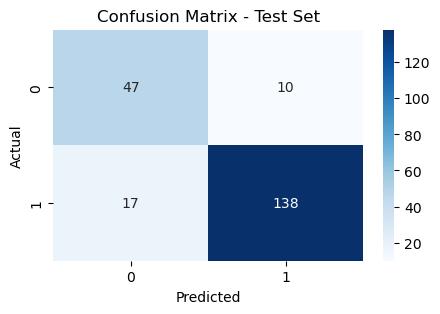

Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.73      0.82      0.78        57
           1       0.93      0.89      0.91       155

    accuracy                           0.87       212
   macro avg       0.83      0.86      0.84       212
weighted avg       0.88      0.87      0.87       212

Accuracy: 0.8726
Precision: 0.9324
Recall: 0.8903
F1 Score: 0.9109


In [158]:
# Test the model
def test_model(model, X_test, y_test):
    y_test_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Test Set')
    plt.show()
    print("Classification Report - Test Set:")
    print(classification_report(y_test, y_test_pred))
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

test_model(best_model, X_test, y_test)    

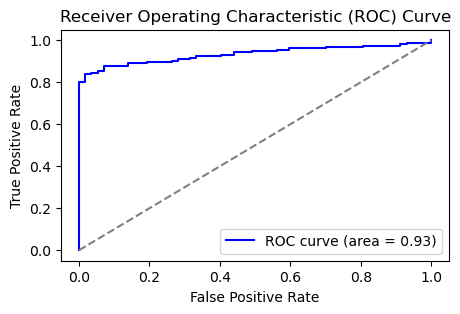

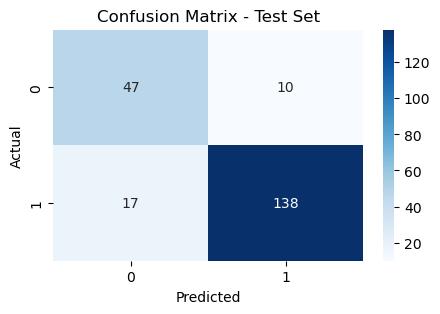

Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.73      0.82      0.78        57
           1       0.93      0.89      0.91       155

    accuracy                           0.87       212
   macro avg       0.83      0.86      0.84       212
weighted avg       0.88      0.87      0.87       212

Accuracy: 0.8726
Precision: 0.9324
Recall: 0.8903
F1 Score: 0.9109


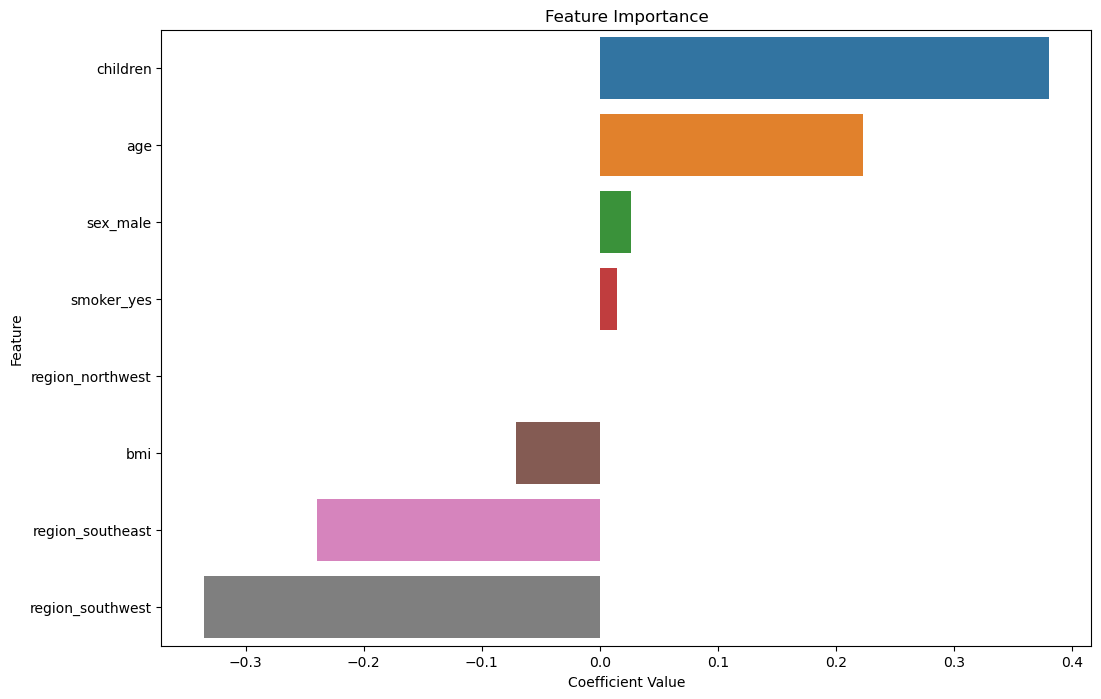

In [159]:
#ROC Curve and AUC
y_test_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

test_model(best_model, X_test, y_test)

# Plot feature importance
def plot_feature_importance(model, feature_names):
    importance = model.coef_[0]
    feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importance, y=feature_importance.index)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(best_model, cleaned_data.drop(columns=['charges']).columns)